In [1]:
import numpy as np 
import pandas as pd 
import os
import keras.backend as K 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In [2]:
import random

train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')


In [3]:
df1 = train_df[train_df['label'] == 'CE']
df2 = train_df[train_df['label'] == 'LAA']
#adjust n to change number of CE data
sampled= df1.sample(n=200, random_state=42)
train_df = pd.concat([sampled, df2],ignore_index=True)

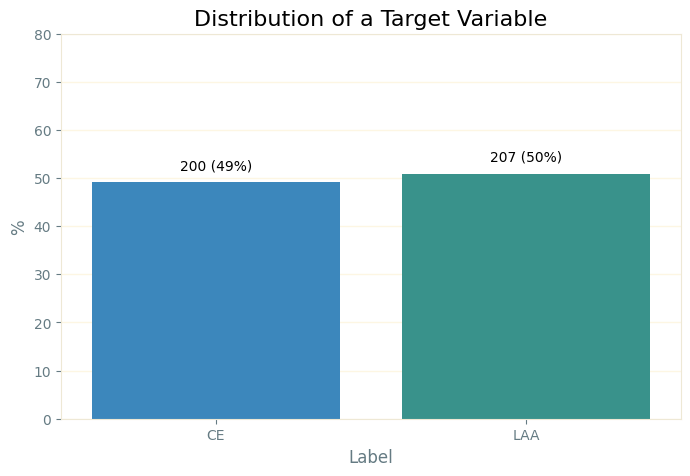

Train Size = 407
Test Size = 4


In [4]:
plt.style.use('Solarize_Light2')
label_percentages = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
label_counts = train_df['label'].value_counts()  

plt.figure(figsize=(8, 5), facecolor='white') 
bar_chart = sns.barplot(x=label_percentages.index, y=label_percentages.values)

bar_chart.set_facecolor('white')

plt.title("Distribution of a Target Variable")
plt.ylabel("%")
plt.xlabel("Label")

plt.ylim(0, 80)

for index, patch in enumerate(bar_chart.patches):
    label = label_percentages.index[index]
    count = label_counts[label]
    percentage = int(label_percentages[label])
    bar_chart.annotate(f'{count} ({percentage}%)',
                      (patch.get_x() + patch.get_width() / 2., patch.get_height() + 2),  
                      ha='center', va='bottom', fontsize=10)

plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))

In [5]:
train_image = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_image = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")

print(f"Number of images in a training set: {len(train_image)}")
print(f"Number of images in a training set: {len(test_image)}")

Number of images in a training set: 754
Number of images in a training set: 4


In [6]:
image_metadata = defaultdict(list)

for idx, img_path in enumerate(train_image):
    img_path = train_image[idx]
    slide_obj = OpenSlide(img_path)    
    image_metadata['image_id'].append(img_path[-12:-4])
    image_metadata['width'].append(slide_obj.dimensions[0])
    image_metadata['height'].append(slide_obj.dimensions[1])
    image_metadata['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    image_metadata['path'].append(img_path)

image_df = pd.DataFrame(image_metadata)
image_df['img_aspect_ratio'] = image_df['width']/image_df['height']
image_df.sort_values(by='image_id', inplace=True)
image_df.reset_index(inplace=True, drop=True)

image_df = image_df.merge(train_df, on='image_id')
image_df.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
2,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
3,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE
4,028989_0,32789,85695,1721.26,/kaggle/input/mayo-clinic-strip-ai/train/02898...,0.382624,5,028989,0,LAA


In [7]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [8]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,4f6fb1_1,10,4f6fb1,1,CE,../input/mayo-clinic-strip-ai/train/4f6fb1_1.tif,1
1,217b27_0,11,217b27,0,CE,../input/mayo-clinic-strip-ai/train/217b27_0.tif,1
2,a4e918_0,11,a4e918,0,CE,../input/mayo-clinic-strip-ai/train/a4e918_0.tif,1
3,2745fc_0,11,2745fc,0,CE,../input/mayo-clinic-strip-ai/train/2745fc_0.tif,1
4,aa2f56_0,9,aa2f56,0,CE,../input/mayo-clinic-strip-ai/train/aa2f56_0.tif,1


In [9]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 407/407 [24:37<00:00,  3.63s/it]

CPU times: user 8min 29s, sys: 2min 4s, total: 10min 34s
Wall time: 24min 37s


In [10]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [11]:
# train split
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train_split, X_test, Y_train_final, Y_test = train_test_split(X_train_split, Y_train_split, test_size=0.2, random_state=42)

In [12]:
!pip install tensorflow numpy pandas tqdm

In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
from tensorflow.keras.utils import to_categorical

# check for one-hot code
def ensure_one_hot(labels, num_classes):
    # 
    if len(labels.shape) == 2 and labels.shape[1] == num_classes:
        return labels
    # one-hot code
    return to_categorical(labels, num_classes=num_classes)

# num_classes = 2
num_classes = 2

#onehot trans
Y_train = ensure_one_hot(Y_train, num_classes)
Y_val = ensure_one_hot(Y_val, num_classes)

# 
print("Y_train shape after one-hot encoding:", Y_train.shape)
print("Y_val shape after one-hot encoding:", Y_val.shape)


Y_train shape after one-hot encoding: (407, 2)
Y_val shape after one-hot encoding: (82, 2)


In [25]:
import numpy as np

# 假设 X_train 是一个包含 RGBA 图像的 NumPy 数组
if X_train.shape[-1] == 4:  # 检查是否是 RGBA 图像
    X_train = X_train[..., :3]  # 去掉透明度通道，保留 RGB
if X_val.shape[-1] == 4:
    X_val = X_val[..., :3]


In [26]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# agumation（train）
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# val generator
val_datagen = ImageDataGenerator(
)

# train generator
train_generator = train_datagen.flow(
    X_train, 
    Y_train, 
    batch_size=32
)

# val （no aug）
val_generator = val_datagen.flow(
    X_val, 
    Y_val, 
    batch_size=32
)


In [41]:
from tensorflow.keras.applications import EfficientNetB0  # 使用更小的模型
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# 假设 X_train, Y_train, X_val, Y_val 已经准备好
# Y_train 和 Y_val 已经是独热编码的格式

# 加载 EfficientNet-B0 的预训练权重
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(128, 128, 3))

# 冻结预训练模型的卷积层
base_model.trainable = False

# 添加自定义分类头
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 2 类分类

# 定义模型
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 数据增强
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)




In [42]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
train_classes = np.argmax(Y_train, axis=1)  # 结果：[0, 1, 1, 2, 0]

# Step 2: 使用 compute_class_weight 计算类别权重
class_weights = compute_class_weight(
    class_weight="balanced",               # 使用平衡模式
    classes=np.unique(train_classes),      # 类别列表（例如 [0, 1, 2]）
    y=train_classes                        # 类别索引
)

# Step 3: 转换为字典形式
class_weights_dict = dict(zip(np.unique(train_classes), class_weights))


In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a callback function
early_stopping = EarlyStopping(
    monitor='val_loss',  #  loss
    patience=5,          # If the validation set loss does not improve for 5 consecutive times, the training is stopped
    restore_best_weights=True  # 
)

model_checkpoint = ModelCheckpoint(
    'efficientnet_b0_best_model.keras',  # The path to save the model file
    save_best_only=True,                 # Save only the models whose validation sets perform best
    monitor='val_loss'                   # loss
)


history = model.fit(
    train_generator,         # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=20,               #
    callbacks=[ early_stopping, model_checkpoint]
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5183 - loss: 0.6934 - val_accuracy: 0.4268 - val_loss: 0.6941
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.4628 - loss: 0.6939 - val_accuracy: 0.4268 - val_loss: 0.6933
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4656 - loss: 0.6935 - val_accuracy: 0.4268 - val_loss: 0.6945
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.4268 - val_loss: 0.6948
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4898 - loss: 0.6932 - val_accuracy: 0.4268 - val_loss: 0.6954
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4988 - loss: 0.6936 - val_accuracy: 0.4268 - val_loss: 0.6953
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5436 - loss: 0.6919 - val_accuracy: 0.4268 - val_loss: 0.6958


In [44]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



batch_size = 32  

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(
    X_test, Y_test,
    batch_size=batch_size,
    shuffle=False  
)

In [45]:
from tensorflow.keras.utils import to_categorical
import numpy as np




num_classes = len(np.unique(Y_test))  

# onehot
Y_test_one_hot = to_categorical(Y_test, num_classes=num_classes)


print("独热编码后的标签形状：", Y_test_one_hot.shape)



独热编码后的标签形状： (65, 2)


In [46]:
import numpy as np

# 假设 X_train 是一个包含 RGBA 图像的 NumPy 数组
if X_test.shape[-1] == 4:  # 检查是否是 RGBA 图像
    X_test = X_test[..., :3]  # 去掉透明度通道，保留 RGB


In [47]:
test_generator = test_datagen.flow(
    X_test, Y_test_one_hot,
    batch_size=batch_size,
    shuffle=False  
)

In [48]:
from tensorflow.keras.models import load_model


best_model = load_model('efficientnet_b0_best_model.keras')


test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f"测试集上的损失: {test_loss}")
print(f"测试集上的准确率: {test_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5775 - loss: 0.6930
测试集上的损失: 0.6929497122764587
测试集上的准确率: 0.5846154093742371


In [49]:
from tensorflow.keras.models import load_model
from sklearn.metrics import log_loss, f1_score
import numpy as np


best_model = load_model('efficientnet_b0_best_model.keras')


predictions = best_model.predict(test_generator)


Y_true = []
for i in range(len(test_generator)):
    _, labels = test_generator[i]
    Y_true.extend(labels)

Y_true = np.array(Y_true)
Y_true = np.argmax(Y_true, axis=1)  # trans back from one-hot

#  Log Loss
log_loss_value = log_loss(Y_true, predictions)
print(f"Log Loss: {log_loss_value}")

# trans percent to class
Y_pred_classes = np.argmax(predictions, axis=1)

# F1 score
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f" F1 : {f1}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Log Loss: 0.6929496532387966
 F1 : 0.4313666915608663
